# Assignment part 2 
8BM050 - 2024-2025

Group number:

Members (name, student number):

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

## Assignment Description

In assignment part 1, you have already encountered the model on caffeine kinetics by Shi et al. [^1], which looked like this:

$$ \begin{align*}
&\frac{\mathrm{d}C^{pl} (t)}{\mathrm{d}t} &=& -k_{12}C^{pl} (t) + k_{21}C^{int} (t) - k_{10}C^{pl} (t) \\
&\frac{\mathrm{d}C^{int} (t)}{\mathrm{d}t} &=& k_{12}C^{pl} (t) - k_{21}C^{int} (t) \\
\end{align*} $$

Where $C^{pl} (t)$ is the concentration of caffeine in the blood plasma, $C^{int} (t)$ is the concentration of caffeine in the interstitial compartment. The parameters are given by $k_{12}$, $k_{21}$, and $k_{10}$. 


### 1. Pharmacodynamic Coupling

In Shi et al. [^1], the authors are interested in the effect of repeated consumption on the immediate effect of caffeine on the blood pressure. For this purpose, the authors coupled the kinetic model in the pevious two equations to a _pharmacodynamic_ model. Their pharmacodynamic model is given by:

$$ P(t) = P_0 + S \cdot \frac{E(t)}{1 + T(t)/T_{50}} $$

This function describes the mean arterial pressure (MAP) based on the basal MAP ($P_0$), the basal pressor effect of caffeine ($S$), and the development of tolerance $T_{50}$. The time-dependent quantities in this pharmacodynamic model are defined by the following differential equations, which are coupled to the state variables in the original model:

$$ \begin{align*}
&\frac{\mathrm{d}E(t)}{\mathrm{d}t} &=& k_{\text{eo}}\left(C^{pl} (t) - E(t)\right) \\
&\frac{\mathrm{d}T(t)}{\mathrm{d}t} &=& k_{\text{tol}}\left(C^{pl} (t) - T(t)\right) \\
\end{align*} $$

Where $k_{\text{eo}}$ represents the rate at which the pressor effect occurs, and $k_{\text{tol}}$ represents the rate at which tolerance occurs.

[^1]: J. Shi, N. L. Benowitz, C. P. Denaro, and L. B. Sheiner, “Pharmacokinetic-pharmacodynamic
modeling of caffeine: Tolerance to pressor effects,” Clinical Pharmacology and Therapeutics, vol.
53, no. 1, pp. 6–14, Jan. 1993, doi: 10.1038/clpt.1993.3.



The original model including this pharmacodynamic coupling are implemented as follows:

In [2]:
def caffeine_model(y, t, k12, k21, k10, k_eo, k_tol):
   
    # caffeine kinetics
    dC_pl = -k12*y[0]+k21*y[1]-k10*y[0]
    dC_int = k12*y[0]-k21*y[1]

    # pharmacodynamic coupling
    dE = k_eo * (y[0] - y[2])
    dT = k_tol * (y[0] - y[3])

    return [dC_pl, dC_int, dE, dT]

We can simulate the model including the pharmacodynamic coupling for 24 hours as follows:

In [4]:
timepoints = np.linspace(0, 24, 1000)
k12 = 1.64
k21 = 1.91
k10 = 0.34
k_eo = 1.73
k_tol = 0.72
y0 = [13.0, 0, 0, 0]

solution = odeint(caffeine_model, y0, timepoints, args=(k12, k21, k10, k_eo, k_tol))

And from this simulation, we can compute the mean arterial pressure over time

In [9]:
def map_model(solution, P_0, S, T_50):
    return P_0 + S * (solution[:,2]) / (1 + solution[:,3]/T_50)

P_0 = 83.3 # mmHg
S = 20.60
T_50 = 0.24

map = map_model(solution, P_0, S, T_50)

And we can visualize the MAP over time

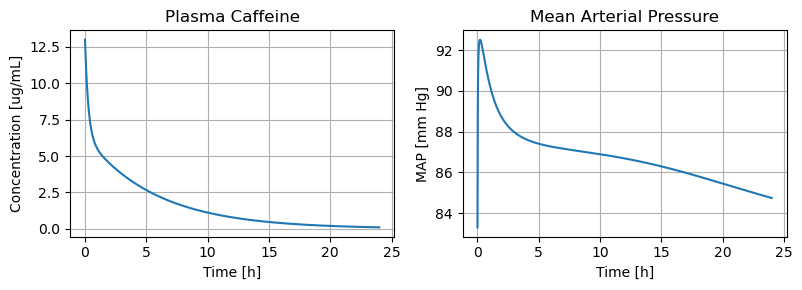

In [11]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].grid()
axs[0].plot(timepoints, solution[:,0])
axs[0].set_xlabel("Time [h]")
axs[0].set_ylabel("Concentration [ug/mL]")
axs[0].set_title("Plasma Caffeine")
axs[1].grid()
axs[1].plot(timepoints, map)
axs[1].set_xlabel("Time [h]")
axs[1].set_ylabel("MAP [mm Hg]")
axs[1].set_title("Mean Arterial Pressure")
plt.tight_layout()



### 2. Extending the Model
In this model above, we have not accounted for caffeine absorption from a possible oral dose, such as coffee. Around 16% of caffeine from an oral dose is absorbed by the stomach [^2], while the rest is absobed through the intestines. We can model this by adding two compartments for the stomach and gut, respectively:

$$ \begin{align*}
&\frac{\mathrm{d}c^{\text{sto}} (t)}{\mathrm{d}t} = -k_a c^{\text{sto}} (t) \\
&\frac{\mathrm{d}c^{\text{gut}} (t)}{\mathrm{d}t} = k_a \left(f_{\text{gut}} c^{\text{sto}} (t) - c^{\text{gut}}(t)\right) \end{align*}
$$

Here, $c^{\text{sto}}$ and $c^{\text{gut}}$ describe the _mass_ of caffeine in $\mu \mathrm{g}$ in the stomach and the gut, respectively. $k_a$ is the rate parameter of gastrointestinal transit and absorption, which has a typical value of $12.00 \text{ h}^{-1}$, and $f_{\text{gut}}$ is the fraction of caffeine that is absorbed by the gut, which is set at $0.84$.

We can connect the gut compartment and the stomach compartment to the plasma as follows:
$$
\frac{\mathrm{d}C^{pl} (t)}{\mathrm{d}t} = -k_{12}C^{pl} (t) + k_{21}C^{int} (t) - k_{10}C^{pl} (t) + \frac{f_{\text{bio}}k_a}{V_cW} \left(c^{\text{gut}} (t) + (1 - f_{\text{gut}}) c^{\text{sto}} (t) \right)
$$

Where $f_{\text{bio}}$ is the fractional bioavailability, which is set at $0.984$. $V_c$ is the compartment volume, which is used to convert from $\mu  \mathrm{g}$ to $\mu \text{g mL}^{-1}$, and has a value of $0.31 \cdot 10^3 \text{ mL kg}^{-1}$. $W$ represents the body weight of the individual in $\text{kg}$. 

[^2]: T. E. Chvasta and A. R. Cooke, “Emptying and Absorption of Caffeine from the Human Stomach,” Gastroenterology, vol. 61, no. 6, pp. 838–843, Dec. 1971, doi: 10.1016/ S0016-5085(19)33396-7

#### 2.1. Preparatory Task 1

Your first task is to extend the model implemented above to also include the stomach and gut equations. You can simulate the model for several values of the body weight parameter to investigate the effect of body weight on caffeine kinetics. For simulation, you can use the following initial conditions, based on the caffeine content of an espresso.

- $c^{\text{sto}} (0) = 212 \cdot 10^3 \text{ }\mu\mathrm{g}$
- $c^{\text{gut}} (0) = 0.0 \text{ }\mu\mathrm{g}$
- $C^{\text{pl}} (0) = 0.0  \text{ }\mu\mathrm{g} \text{ mL}^{-1}$
- $C^{\text{int}} (0) = 0.0 \text{ }\mu\mathrm{g} \text{ mL}^{-1}$

In [ ]:
# implementation here

### 3. Multiple Doses
Now we have simulated the effect of caffeine over only one dose of espresso at $t = 0$. However, we may want to simulate multiple doses in a row. To do this, we have to combine multiple simulations, and adjust the initial conditions every time. An example the following simple system can be:

$$\frac{\mathrm{d}x}{\mathrm{d}t} = -kx $$

Where we have an initial value of $x = 2.0$ at $t = 0$, and add another dose of $2.0$ at $t = 4$.

We can first implement the model:

In [12]:
def simple_model(x, t, k):
    return -k*x

k = 0.5
x0 = 2.0

We can then do the first simulation, up to $t=4.0$

In [17]:
simulation_1 = odeint(simple_model, x0, np.linspace(0,4,100), args=(k,))

We can then do the second simulation, taking the final timepoint of the first as initial condition and adding the second dose.

In [ ]:
# the new initial condition is the end of simulation 1 plus the dose
x0_2 = simulation_1[-1] + 2.0

# simulate with the new initial condition, starting where the previous simulation ended
simulation_2 = odeint(simple_model, x0_2, np.linspace(4,10,100), args=(k,))

We can then combine both simulations and visualize the result.

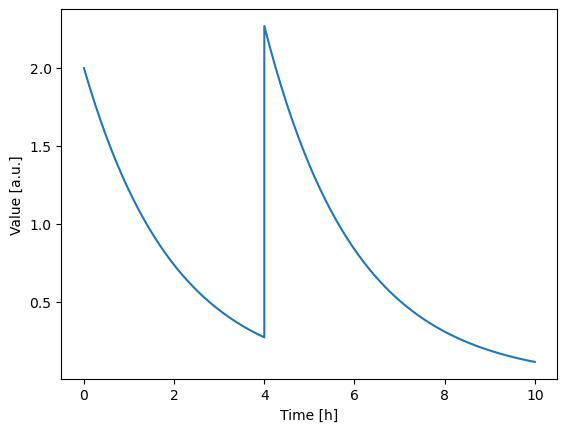

In [23]:
# combine the timepoints
timepoints = np.concatenate([np.linspace(0,4,100), np.linspace(4,10,100)])
simulation = np.concatenate([simulation_1, simulation_2])

# visualize
plt.plot(timepoints, simulation)
plt.xlabel("Time [h]")
plt.ylabel("Value [a.u.]")
plt.show()

#### 3.1. Preparatory Task 2
Combine two simulations of the full caffeine model (including the pharmacodynamic coupling and the gut and stomach compartments) to be able to simulate two doses of espresso. One at $t = 0$, and one at $t = 2$. What is the difference between the first and the second peak of the MAP?

### 4. Design an Experiment
You now have an experimental setup to investigate the effects of different caffeine dosages on the mean arterial pressure. Additionally, you can vary the body weight to see the effect of differences in body composition. 

#### 4.1 Assignment Task
Use the results you obtained in your initial exploration to formulate a research question you can investigate using the final model. Investigate the research question using the model code you have developed in preparatory tasks 1 and 2 and show your results in a poster. The poster should contain five components:
1. Introduction where you briefly describe the components of interest in this work 
2. Research question
3. Experiments where you highlight your experimental procedure
4. Results where you show and interpret figures that help to answer your research question.
5. Discussion where you draw conclusions from the results and indicate (some) limitations of this strategy.

The only requirement on the experiments is that the work done in preparatory tasks 1 and 2, as well as the MAP computation **must** be visible from the experiments you selected. Concretely, this means that your experiments must contain:
1. A computation of the MAP
2. Oral administration of caffeine
3. Multiple sequential simulations

### Deliverables
For this assignment your **only** deliverable is the poster. The answers to assignment tasks 1 and 2 do not have to be handed in. You will need those answers to do assignment task 3, so they are implicitly included in the poster already.

### Grading
The assignment will be graded based on your poster (handed in through Canvas and presented at the poster session in week 6) and the presentation of the poster during the poster session. The rubric for this assignment is included in the Canvas description of the assignment.

### Plagiarism, Presence at the Poster Session
- For your poster to be graded, you need to be present at the poster session. Group members that are not present will get a grade of zero (0) for assignment part 2. If you are unable to attend the poster session for a valid reason, please send an e-mail _before the poster session_ to Max de Rooij (m.d.rooij@tue.nl) including the reason for your absence. Exceptions can be made for valid reasons such as illness, or exams for other courses.
- Plagiarism will result in a grade of zero (0) for assignment part 2, and you may face consequences based on the university-wide plagiarism policy.